<a href="https://colab.research.google.com/github/root-epifit/madmo-adv/blob/my_exercise/homeworks/hw1_boosting_and_explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ №1

# Homework 1
## Gradient boosting on temporal data and feature importances


In [1]:
! pip install scikit-learn==1.0
! pip install optuna
! pip install shap

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

Today we will work with [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. It is one of the most popular frameworks these days that shows both great quality and performance.

There are another great frameworks (listed below). However, we will stick to `LightGBM` for this task.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Novel framework by Yandex company tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

Some simple preprocessing is done for you. 

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

__Please, use [`shap`](https://github.com/slundberg/shap) and interpret the generated plots (with a brief summary).__

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data.

In [2]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt"\
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

File ‘UCI HAR Dataset.zip’ already there; not retrieving.

Archive:  UCI HAR Dataset.zip
caution: filename not matched:  UCI HAR Dataset/train/y_train.txtUCI HAR Dataset/test/X_test.txt


In [3]:
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt"

Archive:  UCI HAR Dataset.zip


In [4]:
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

Archive:  UCI HAR Dataset.zip


###### Проверяем загрузки

In [5]:
! head -n 1 "UCI HAR Dataset/train/X_train.txt"

  2.8858451e-001 -2.0294171e-002 -1.3290514e-001 -9.9527860e-001 -9.8311061e-001 -9.1352645e-001 -9.9511208e-001 -9.8318457e-001 -9.2352702e-001 -9.3472378e-001 -5.6737807e-001 -7.4441253e-001  8.5294738e-001  6.8584458e-001  8.1426278e-001 -9.6552279e-001 -9.9994465e-001 -9.9986303e-001 -9.9461218e-001 -9.9423081e-001 -9.8761392e-001 -9.4321999e-001 -4.0774707e-001 -6.7933751e-001 -6.0212187e-001  9.2929351e-001 -8.5301114e-001  3.5990976e-001 -5.8526382e-002  2.5689154e-001 -2.2484763e-001  2.6410572e-001 -9.5245630e-002  2.7885143e-001 -4.6508457e-001  4.9193596e-001 -1.9088356e-001  3.7631389e-001  4.3512919e-001  6.6079033e-001  9.6339614e-001 -1.4083968e-001  1.1537494e-001 -9.8524969e-001 -9.8170843e-001 -8.7762497e-001 -9.8500137e-001 -9.8441622e-001 -8.9467735e-001  8.9205451e-001 -1.6126549e-001  1.2465977e-001  9.7743631e-001 -1.2321341e-001  5.6482734e-002 -3.7542596e-001  8.9946864e-001 -9.7090521e-001 -9.7551037e-001 -9.8432539e-001 -9.8884915e-001 -9.1774264e-001 -1.0000

In [6]:
! head -n 2 "UCI HAR Dataset/train/y_train.txt"

5
5


In [7]:
! head "UCI HAR Dataset/activity_labels.txt"

1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING


In [8]:
! rm unique_columns*
#! wget --no-check-certificate --content-disposition https://github.com/root-epifit/madmo-adv/blob/my_exercise/homeworks/unique_columns.txt
! curl -LJ0 https://raw.githubusercontent.com/root-epifit/madmo-adv/my_exercise/homeworks/unique_columns.txt > unique_columns.txt
print("File contents:")
! head -n 2 unique_columns.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2050  100  2050    0     0  18141      0 --:--:-- --:--:-- --:--:-- 18141
File contents:
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,206,207,208,209,210,211,212,226,227,22

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")

activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [11]:
X_train

array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
         0.17994061, -0.05862692],
       [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
         0.18028889, -0.05431672],
       [ 0.27965306, -0.01946716, -0.11346169, ..., -0.84893347,
         0.18063731, -0.04911782],
       ...,
       [ 0.27338737, -0.01701062, -0.04502183, ..., -0.77913261,
         0.24914484,  0.04081119],
       [ 0.28965416, -0.01884304, -0.15828059, ..., -0.78518142,
         0.24643223,  0.02533948],
       [ 0.35150347, -0.01242312, -0.20386717, ..., -0.78326693,
         0.24680852,  0.03669484]])

In [12]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [13]:
unique_columns = np.genfromtxt("unique_columns.txt", delimiter=",").astype(int)
X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

In [14]:
unique_columns.shape

(540,)

###### PCA could be useful in this case. E.g.

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(0.99)

In [17]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [18]:
X_train_pca.shape

(7352, 179)

In [19]:
X_test_pca.shape

(2947, 179)

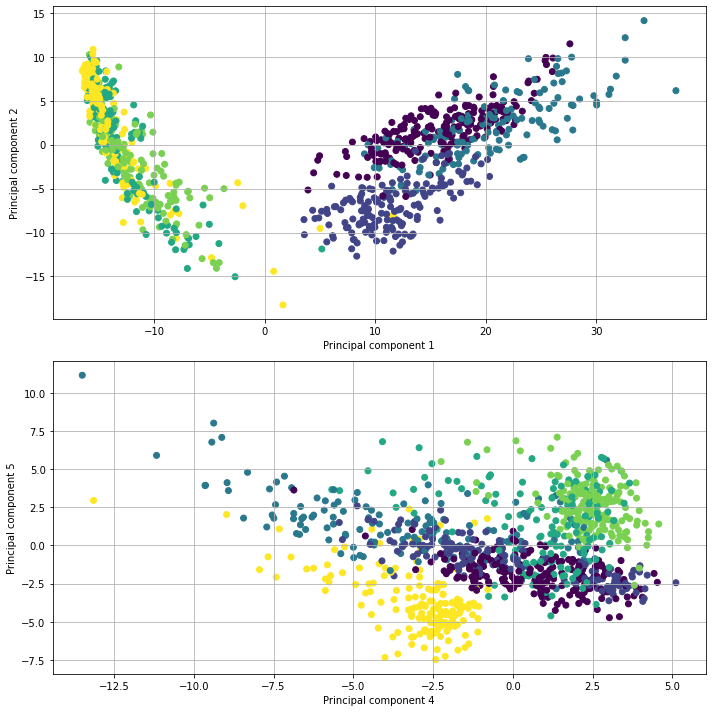

In [20]:
NUM_OBSERVATIONS = 1000

components = [[0,1],[3,4]]

fig, axs = plt.subplots(nrows=2, 
                        ncols=1, 
                        figsize=(10,10), 
                        #sharex='col', 
                        #sharey='row' ,
                        tight_layout=True
                        )


for i, item in enumerate(components):
    #axs[i].figure(figsize=(5,5))
    axs[i].scatter(X_train_pca[:NUM_OBSERVATIONS, item[0]], 
            X_train_pca[:NUM_OBSERVATIONS, item[1]], 
            c=y_train[:NUM_OBSERVATIONS],
             )
    axs[i].grid()
    axs[i].set_xlabel(f"Principal component {item[0]+1}")
    axs[i].set_ylabel(f"Principal component {item[1]+1}")
    

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some hyperparams by hand.

In [21]:
# YOUR CODE HERE

# Example: https://rpubs.com/burakh/har_xgb

###### imports & defs

In [22]:
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import statistics

import pandas as pd

from shap import TreeExplainer, summary_plot

import optuna

lightgbm.__version__

def print_metrics(y_test:list, y_pred:list)-> None: 
    print("\nAccuracy:")
    for class_ in range(int(y_test.min()),int(y_test.max()+1)):
        acc = accuracy_score(y_test[np.where(y_test==class_)], 
                         y_pred[np.where(y_test==class_)])
        print(f'Class = {class_}, accuracy = {acc:.3}')
    
    total_acc = accuracy_score(y_test, y_pred)
    print(f'Overall accuracy = {total_acc:.3}\n\n')
    print(classification_report(y_test, y_pred))
    return 

def get_metrics(y_test:list, y_pred:list)-> list: 
    rc = []
    for class_ in range(int(y_test.min()),int(y_test.max()+1)):
        acc = accuracy_score(y_test[np.where(y_test==class_)], 
                         y_pred[np.where(y_test==class_)])
        rc.append(acc)

    total_acc = accuracy_score(y_test, y_pred)
    rc.append(total_acc)

    return rc

###### Baseline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe3d888a210>]],
      dtype=object)

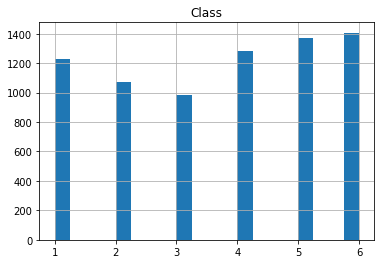

In [23]:
df_y_train = pd.DataFrame({'Class':y_train})
df_y_train.hist(bins=20)

In [24]:
df_y_train.value_counts()

Class
6.0      1407
5.0      1374
4.0      1286
1.0      1226
2.0      1073
3.0       986
dtype: int64

LGBMClassifier()

Accuracy:
Class = 1, accuracy = 0.972
Class = 2, accuracy = 0.941
Class = 3, accuracy = 0.752
Class = 4, accuracy = 0.849
Class = 5, accuracy = 0.944
Class = 6, accuracy = 0.955
Overall accuracy = 0.907


              precision    recall  f1-score   support

         1.0       0.86      0.97      0.91       496
         2.0       0.90      0.94      0.92       471
         3.0       0.94      0.75      0.83       420
         4.0       0.89      0.85      0.87       491
         5.0       0.87      0.94      0.91       532
         6.0       1.00      0.96      0.98       537

    accuracy                           0.91      2947
   macro avg       0.91      0.90      0.90      2947
weighted avg       0.91      0.91      0.91      2947


Confusion matrix: [[482   0  14   0   0   0]
 [ 21 443   7   0   0   0]
 [ 57  47 316   0   0   0]
 [  0   1   0 417  71   2]
 [  0   0   0  30 502   0]
 [  0   0   0  23   1 513]]



Text(0.5, 15.0, 'Predicted value')

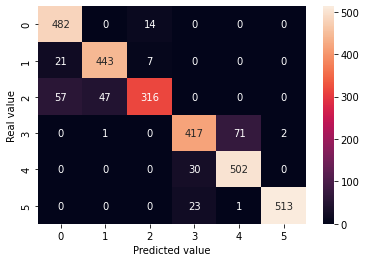

In [25]:
model = LGBMClassifier()
model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)

# параметры модели по дефолту
print(model)

# метрики
print_metrics(y_test, y_pred)

# Confusion matrix
cf_m = confusion_matrix(y_test, y_pred)
print(f'\nConfusion matrix: {cf_m}\n')

sns.heatmap(cf_m, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

###### Feature importance (with shap)

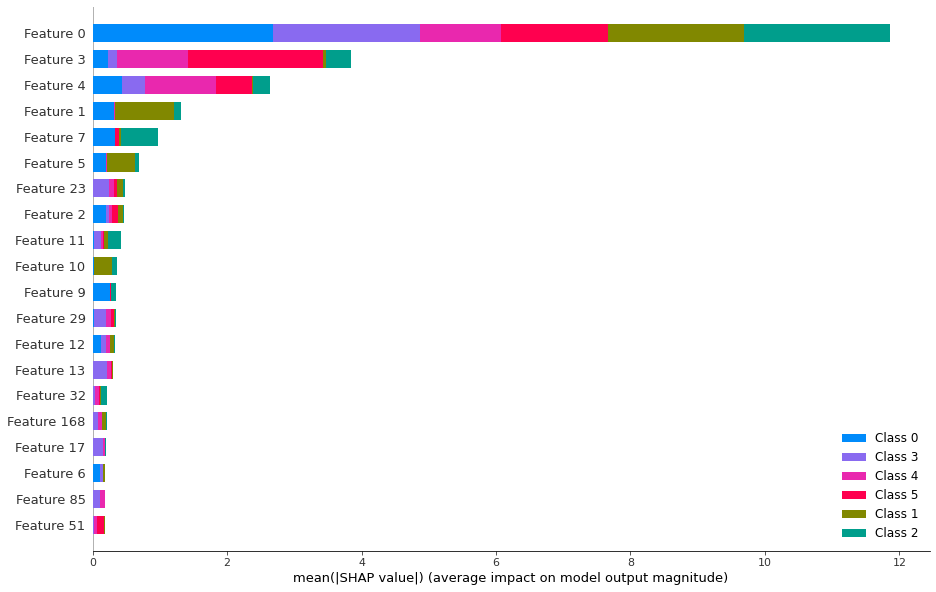

In [26]:
explainer = TreeExplainer(model)
shap_values = explainer.shap_values(X_test_pca) ###
summary_plot(shap_values, X_test_pca, plot_type="bar", plot_size=(15, 10)) ###


Accuracy:
Class = 1, accuracy = 0.915
Class = 2, accuracy = 0.873
Class = 3, accuracy = 0.645
Class = 4, accuracy = 0.609
Class = 5, accuracy = 0.846
Class = 6, accuracy = 0.92
Overall accuracy = 0.807


              precision    recall  f1-score   support

         1.0       0.79      0.92      0.85       496
         2.0       0.85      0.87      0.86       471
         3.0       0.82      0.65      0.72       420
         4.0       0.71      0.61      0.65       491
         5.0       0.71      0.85      0.77       532
         6.0       0.99      0.92      0.95       537

    accuracy                           0.81      2947
   macro avg       0.81      0.80      0.80      2947
weighted avg       0.81      0.81      0.81      2947


Confusion matrix for 7 features: [[454   7  35   0   0   0]
 [ 37 411  23   0   0   0]
 [ 84  65 271   0   0   0]
 [  0   0   0 299 186   6]
 [  0   0   0  82 450   0]
 [  0   0   0  43   0 494]]



[Text(469.23636363636354, 0.5, 'Real values'),
 Text(0.5, 24.0, 'Predicted values'),
 Text(0.5, 1.0, 'All features')]

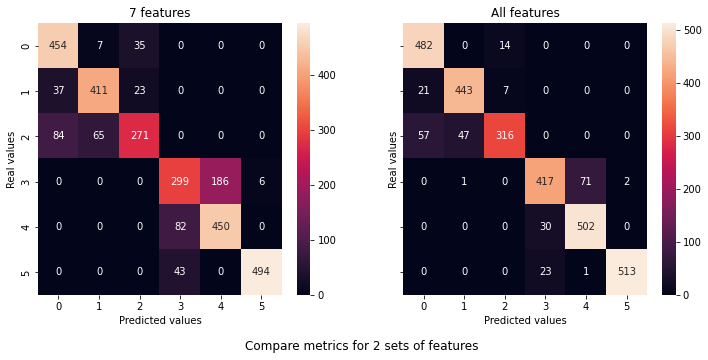

In [27]:
# Проверим модель на 7-ми наиболее важных фичах

most_important_features = [0,1,2,3,4,5,7]
X_train_pca_mif = X_train_pca[:,most_important_features]
X_test_pca_mif = X_test_pca[:,most_important_features]

model = LGBMClassifier()
model.fit(X_train_pca_mif, y_train)

y_pred = model.predict(X_test_pca_mif)

# метрики
print_metrics(y_test, y_pred)

# Confusion matrix
cf_m_mif = confusion_matrix(y_test, y_pred)
print(f'\nConfusion matrix for 7 features: {cf_m_mif}\n')

fig, axs = plt.subplots(1,2, 
                        figsize=(12,5),
                        #sharex='col', 
                        sharey='row' ,
                        )

plt.ylabel("Real value")
plt.xlabel("Predicted value")

st = fig.suptitle('Compare metrics for 2 sets of features')
st.set_y(0.0)

h1=sns.heatmap(cf_m_mif, annot=True, fmt="d", ax=axs[0])
h1.set(title="7 features",
      xlabel="Predicted values",
      ylabel="Real values",)

h2=sns.heatmap(cf_m, annot=True, fmt="d", ax=axs[1])
h2.set(title="All features",
      xlabel="Predicted values",
      ylabel="Real values",)

###### Manual parameters

------------------------
n_estimators=50
LGBMClassifier(max_depth=1, n_estimators=50, warm_start=True)
------------------------
n_estimators=100
LGBMClassifier(max_depth=1, warm_start=True)
------------------------
n_estimators=300
LGBMClassifier(max_depth=1, n_estimators=300, warm_start=True)
------------------------
n_estimators=500
LGBMClassifier(max_depth=1, n_estimators=500, warm_start=True)


Text(0, 0.5, 'accuracy')

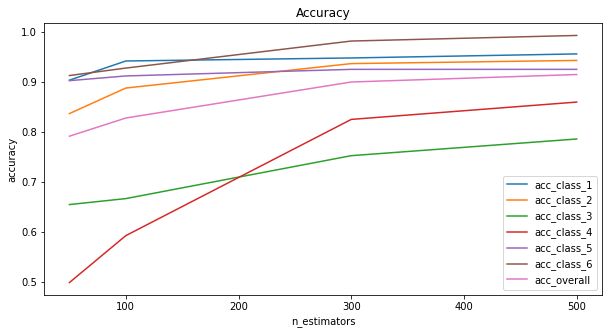

In [28]:
estimators = [50, 100, 300, 500]

model = LGBMClassifier(max_depth=1, 
                       learning_rate=0.1, 
                       warm_start=True)
results = []

for n_estimator in estimators:
    print("------------------------")
    print(f"n_estimators={n_estimator}")
    model.n_estimators=n_estimator
    print(model)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    results.append(get_metrics(y_test, y_pred))

# Визуализируем
results = np.array(results)

data = {}
for i in range(results.shape[1]):
    data['acc_class_'+str(i+1) if i+1 != 7 else 'acc_overall']=results[:,i]

df = pd.DataFrame(data=data, index=estimators)
df.plot(figsize=(10,5))
plt.title('Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')

Please, write down your thoughts on the experiment results.

*Number of features can be reduced to 7-10 features with 0.1 drop in classificatoin quality: Ooverall accuracy when using all features was 0,91 against 0.81 for 7 features*

*Lokks, that the optimal value for n_estimators parameter is in the range 250-350*

## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [29]:
# YOUR CODE HERE

In [30]:
from optuna.integration import LightGBMPruningCallback


# One-Hot encoding
def encode(y):
    y_enc = [] #np.zeros((6,y.shape[0]))
    for class_ in range(0,6):
        y_tmp = y.copy()
        y_tmp[np.where(y != class_+1)] = 0
        y_tmp[np.where(y == class_+1)] = 1
        y_enc.append(y_tmp) #.reshape(y.shape[0],)
    
    return np.array(y_enc).transpose()

def objective(trial, X_train, y_train, X_test, y_test):
        
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 650, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.5),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 1, 5),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        #"lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        #"lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        #"bagging_fraction": trial.suggest_float(
        #    "bagging_fraction", 0.2, 0.95, step=0.1
        #),
        #"bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        #"feature_fraction": trial.suggest_float(
        #    "feature_fraction", 0.2, 0.95, step=0.1
        #),
    }

    #cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    model = LGBMClassifier(objective='multiclass', 
                           **param_grid)
    model.fit(
            X_train,
            y_train,
            #eval_set=[(X_train, y_train)],
            #eval_metric="accuracy",
            #early_stopping_rounds=100,
            #callbacks=[
            #    LightGBMPruningCallback(trial, "binary_logloss")
            #],  # Add a pruning callback
        )
    
    y_pred = model.predict(X_test)

    #y_test_enc = encode(y_test)
    #y_pred_enc = encode(y_pred)

    return accuracy_score(y_test, y_pred) 

In [31]:
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_train_pca, y_train, X_test_pca, y_test)
study.optimize(func, n_trials=20)

[I 2021-11-08 13:42:03,686] A new study created in memory with name: LGBM Classifier
[I 2021-11-08 13:42:08,943] Trial 0 finished with value: 0.9212758737699356 and parameters: {'n_estimators': 150, 'learning_rate': 0.8844236131654548, 'num_leaves': 940, 'max_depth': 5, 'min_data_in_leaf': 1900}. Best is trial 0 with value: 0.9212758737699356.
[I 2021-11-08 13:42:09,681] Trial 1 finished with value: 0.18221920597217509 and parameters: {'n_estimators': 650, 'learning_rate': 0.5084037933126861, 'num_leaves': 1500, 'max_depth': 1, 'min_data_in_leaf': 4600}. Best is trial 0 with value: 0.9212758737699356.
[I 2021-11-08 13:42:10,321] Trial 2 finished with value: 0.18221920597217509 and parameters: {'n_estimators': 550, 'learning_rate': 1.104840122567043, 'num_leaves': 680, 'max_depth': 2, 'min_data_in_leaf': 7300}. Best is trial 0 with value: 0.9212758737699356.
[I 2021-11-08 13:42:19,184] Trial 3 finished with value: 0.9345096708517137 and parameters: {'n_estimators': 150, 'learning_rate':

In [32]:
print(f"\tBest value (accuracy): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (accuracy): 0.93655
	Best params:
		n_estimators: 250
		learning_rate: 0.32052688286105036
		num_leaves: 2140
		max_depth: 4
		min_data_in_leaf: 1000


------------------------
n_estimators=50
LGBMClassifier(learning_rate=0.32052688286105036, max_depth=4,
               min_data_in_leaf=1000, n_estimators=50, num_leaves=2140)
------------------------
n_estimators=100
LGBMClassifier(learning_rate=0.32052688286105036, max_depth=4,
               min_data_in_leaf=1000, num_leaves=2140)
------------------------
n_estimators=250
LGBMClassifier(learning_rate=0.32052688286105036, max_depth=4,
               min_data_in_leaf=1000, n_estimators=250, num_leaves=2140)
------------------------
n_estimators=300
LGBMClassifier(learning_rate=0.32052688286105036, max_depth=4,
               min_data_in_leaf=1000, n_estimators=300, num_leaves=2140)
------------------------
n_estimators=400
LGBMClassifier(learning_rate=0.32052688286105036, max_depth=4,
               min_data_in_leaf=1000, n_estimators=400, num_leaves=2140)
------------------------
n_estimators=500
LGBMClassifier(learning_rate=0.32052688286105036, max_depth=4,
               min_data_i

Text(0, 0.5, 'accuracy')

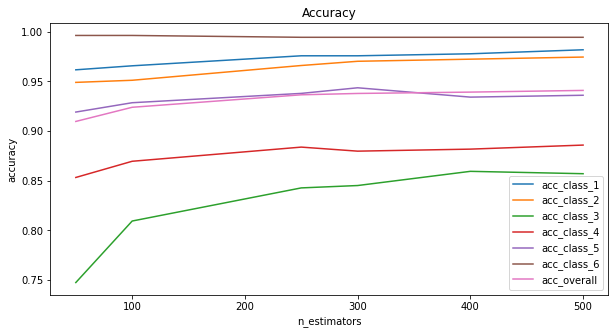

In [33]:
# Проверяем, что n_estimators = 450 - лучший

estimators = [50, 100, 250, 300, 400, 500]

model = LGBMClassifier(**study.best_params)
results = []

for n_estimator in estimators:
    print("------------------------")
    print(f"n_estimators={n_estimator}")
    model.n_estimators=n_estimator
    print(model)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    results.append(get_metrics(y_test, y_pred))

# Визуализируем
results = np.array(results)

data = {}
for i in range(results.shape[1]):
    data['acc_class_'+str(i+1) if i+1 != 7 else 'acc_overall']=results[:,i]

df = pd.DataFrame(data=data, index=estimators)
df.plot(figsize=(10,5))
plt.title('Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')

### Part 3. Interpret the model predictions
Despite you are free to use any approaches to interpret the model predictions, please use [`shap`](https://github.com/slundberg/shap) to build some plots (e.g. the ones we've seen on week02) and try to interpret them.

In [34]:
import shap


# YOUR CODE HERE

In [64]:
best_model = LGBMClassifier(**study.best_params)

best_model.fit(X_train_pca, y_train)

y_pred = best_model.predict(X_test_pca)

###### Feature importance (summary)

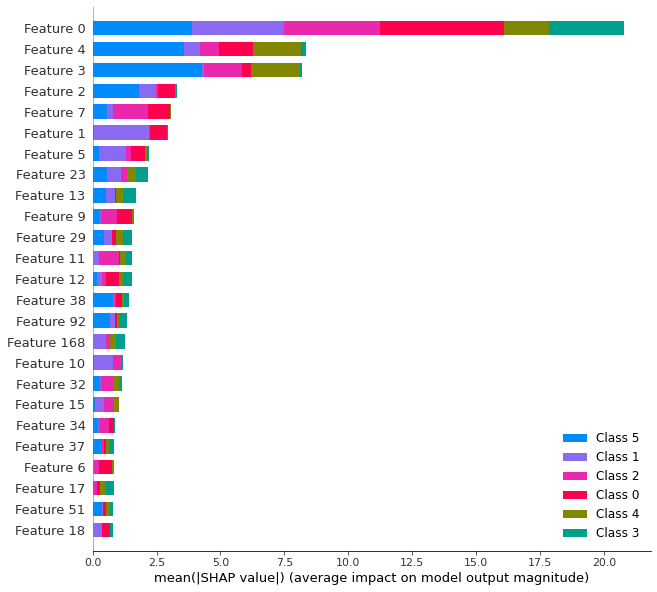

In [59]:
explainer = TreeExplainer(best_model)
shap_test = explainer.shap_values(X_test_pca)
shap.summary_plot(shap_test, X_test_pca,
                      max_display=25, plot_size=(10,10))

###### Feature Importance details for classes

------------------------
Clasa = 1


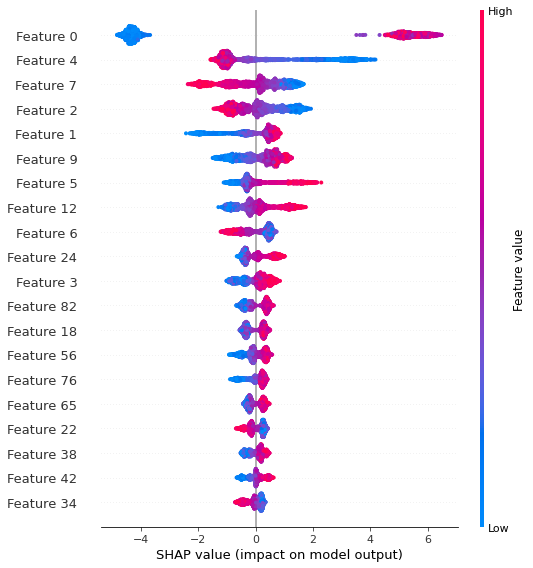

------------------------
Clasa = 2


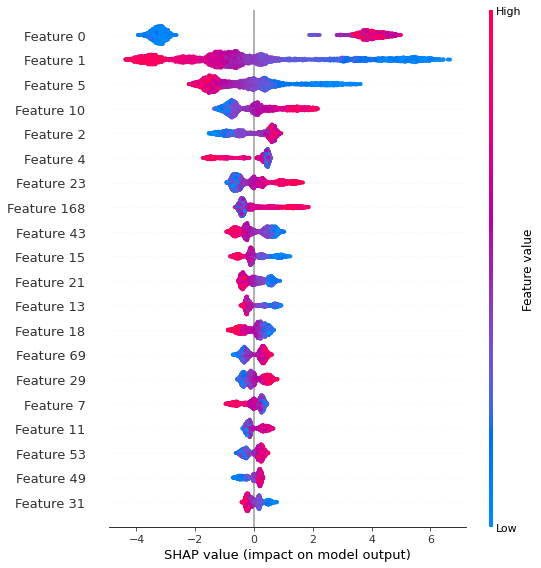

------------------------
Clasa = 3


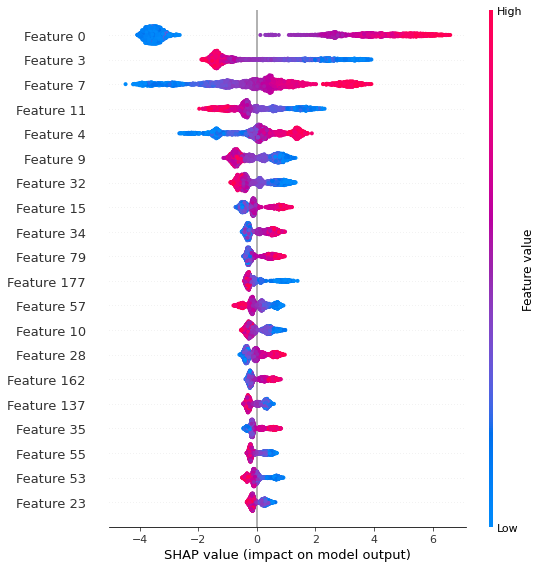

------------------------
Clasa = 4


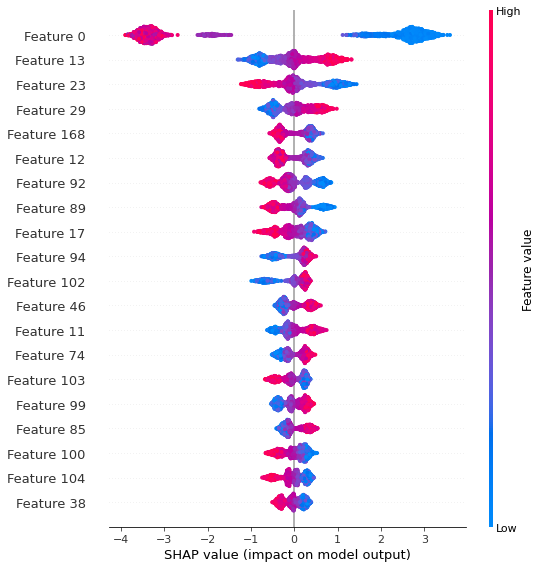

------------------------
Clasa = 5


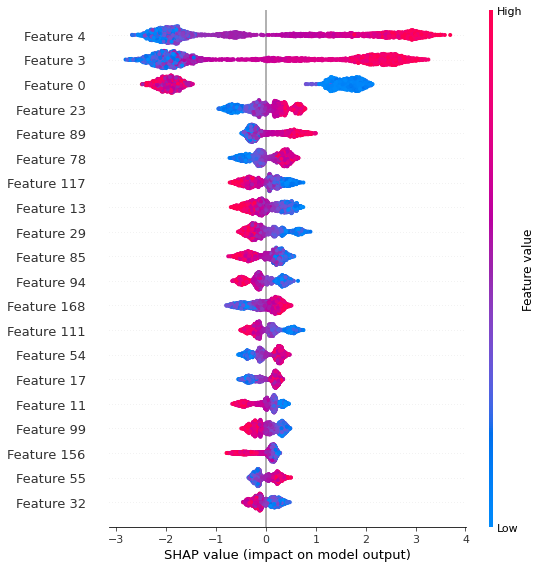

------------------------
Clasa = 6


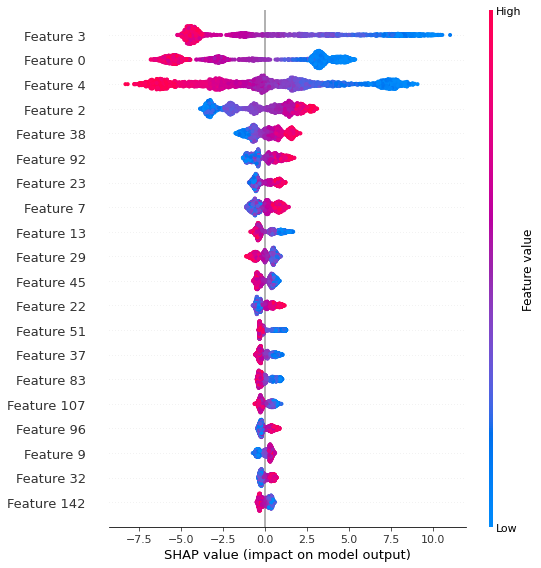

In [37]:
# Feature Importance for Classes

CLASS_ID_S = [1,2,3,4,5,6]

for class_ in CLASS_ID_S:
    id= class_-1
    print('------------------------')
    print(f'Clasa = {class_}')
    shap_values_ks = shap_test[id]
    shap.summary_plot(shap_values_ks, X_test_pca)

In [66]:
df = pd.DataFrame({'Real':y_test, 'Prediction':y_pred})
df.head(2)

,Real,Prediction
0,5.0,5.0
1,5.0,5.0


In [67]:
# Feature contribution for the single prediction

# Class = 5
id = 4
prediction_id=0 # Class =5 распознан как Class=5

shap_values = shap_test[id]
expected_value = explainer.expected_value[id] #shap_values[0,-1]
shap.initjs()

shap.force_plot(expected_value, shap_values[0,:], X_test_pca[0,:])

_Your thoughts about the plots and model behaviour._